In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random
random.seed(1100038344)
import survivalstan
import numpy as np
import pandas as pd
from stancache import stancache
from matplotlib import pyplot as plt

/Users/jburos/anaconda/envs/python3/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "
INFO:stancache.seed:Setting seed to 1245502385


In [2]:
print(survivalstan.models.pem_survival_model)

/*  Variable naming:
 // dimensions
 N          = total number of observations (length of data)
 S          = number of sample ids
 T          = max timepoint (number of timepoint ids)
 M          = number of covariates
 
 // main data matrix (per observed timepoint*record)
 s          = sample id for each obs
 t          = timepoint id for each obs
 event      = integer indicating if there was an event at time t for sample s
 x          = matrix of real-valued covariates at time t for sample n [N, X]
 
 // timepoint-specific data (per timepoint, ordered by timepoint id)
 t_obs      = observed time since origin for each timepoint id (end of period)
 t_dur      = duration of each timepoint period (first diff of t_obs)
 
*/
// Jacqueline Buros Novik <jackinovik@gmail.com>

data {
  // dimensions
  int<lower=1> N;
  int<lower=1> S;
  int<lower=1> T;
  int<lower=0> M;
  
  // data matrix
  int<lower=1, upper=N> s[N];     // sample id
  int<lower=1, upper=T> t[N];     // timepoint id
  int<

In [3]:
d = survivalstan.sim.sim_data_exp_correlated(N=100,
                                             censor_time=20,
                                             rate_form='1 + sex',
                                             rate_coefs=[-3, 0.5])
d['age_centered'] = d['age'] - d['age'].mean()
d.head()

,age,sex,rate,true_t,t,event,index,age_centered
0,46,female,0.049787,2.155200,2.155200,True,0,-10.07
1,40,female,0.049787,1.759737,1.759737,True,1,-16.07
2,62,female,0.049787,5.800892,5.800892,True,2,5.93
3,51,male,0.082085,9.295511,9.295511,True,3,-5.07
4,57,male,0.082085,11.989712,11.989712,True,4,0.93


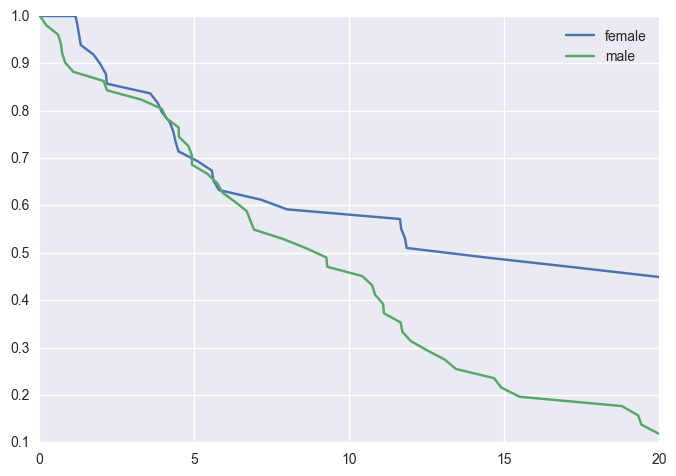

In [4]:
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t', label='male')
plt.legend()

In [5]:
dlong = survivalstan.prep_data_long_surv(df=d, event_col='event', time_col='t')

In [6]:
dlong.head()

,age,sex,rate,true_t,t,event,index,age_centered,key,end_time,end_failure
0,46,female,0.049787,2.1552,2.1552,True,0,-10.07,1,2.155200,True
1,46,female,0.049787,2.1552,2.1552,True,0,-10.07,1,1.759737,False
8,46,female,0.049787,2.1552,2.1552,True,0,-10.07,1,0.611604,False
14,46,female,0.049787,2.1552,2.1552,True,0,-10.07,1,1.343962,False
17,46,female,0.049787,2.1552,2.1552,True,0,-10.07,1,1.292479,False


In [22]:
testfit = survivalstan.fit_stan_survival_model(
    model_cohort = 'test model',
    model_code = survivalstan.models.pem_survival_model,
    df = dlong,
    sample_col = 'index',
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    formula = '~ age_centered + sex',
    iter = 1000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    )


INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_1.model_code_49777972005.pystan_2_12_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Loading result from cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_1.model_code_49777972005.pystan_2_12_0_0.stanfit.chains_4.data_62934328991.iter_1000.seed_9001.pkl
INFO:stancache.stancache:sampling: Loading result from cache
/Users/jburos/anaconda/envs/python3/lib/python3.5/site-packages/stanity/psis.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif sort == 'in-place':
/Users/jburos/anaconda/envs/python3/lib/python3.5/site-packages/stanity/psis.py:246: VisibleDeprecationWarning: using a non-integer number instead of an integer 

In [23]:
survivalstan.utils.print_stan_summary([testfit], pars='lp__')

            mean   se_mean         sd        2.5%         50%       97.5%      Rhat
lp__ -265.630993  6.845667  42.199524 -339.473482 -267.387188 -185.810936  1.043296


In [24]:
survivalstan.utils.print_stan_summary([testfit], pars='log_baseline_raw')

                          mean   se_mean        sd      2.5%       50%     97.5%      Rhat
log_baseline_raw[0]   0.018146  0.002697  0.120612 -0.210630  0.011886  0.289749  0.998700
log_baseline_raw[1]   0.015887  0.002932  0.131113 -0.240545  0.009027  0.316888  0.998763
log_baseline_raw[2]   0.018300  0.003149  0.140812 -0.258912  0.011482  0.346949  1.001268
log_baseline_raw[3]   0.013725  0.002715  0.121424 -0.229768  0.006894  0.282052  1.000316
log_baseline_raw[4]   0.010146  0.002893  0.129370 -0.254684  0.005597  0.297466  0.998705
log_baseline_raw[5]   0.016281  0.002816  0.125943 -0.228651  0.010100  0.294724  1.000108
log_baseline_raw[6]   0.012232  0.003179  0.142155 -0.281754  0.008568  0.346755  0.999214
log_baseline_raw[7]   0.010112  0.002727  0.121969 -0.251361  0.004707  0.277274  0.998993
log_baseline_raw[8]   0.007728  0.003001  0.134213 -0.263466  0.004178  0.286472  0.999104
log_baseline_raw[9]   0.012426  0.002771  0.123933 -0.239824  0.006778  0.280111  0.999710

/Users/jburos/anaconda/envs/python3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


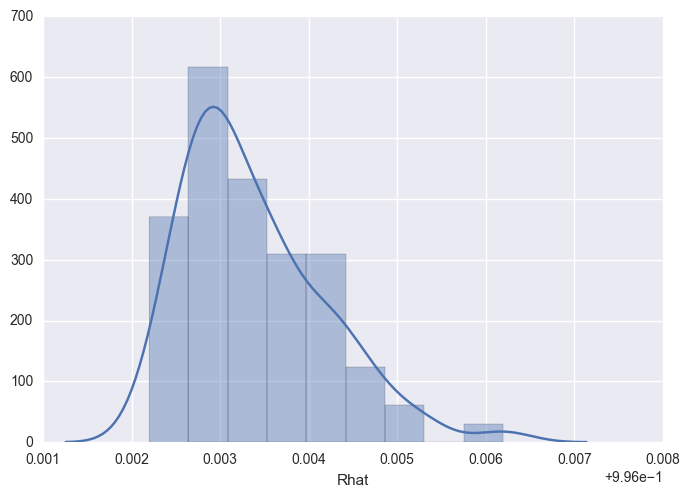

In [18]:
survivalstan.utils.plot_stan_summary([testfit], pars='log_baseline_raw')

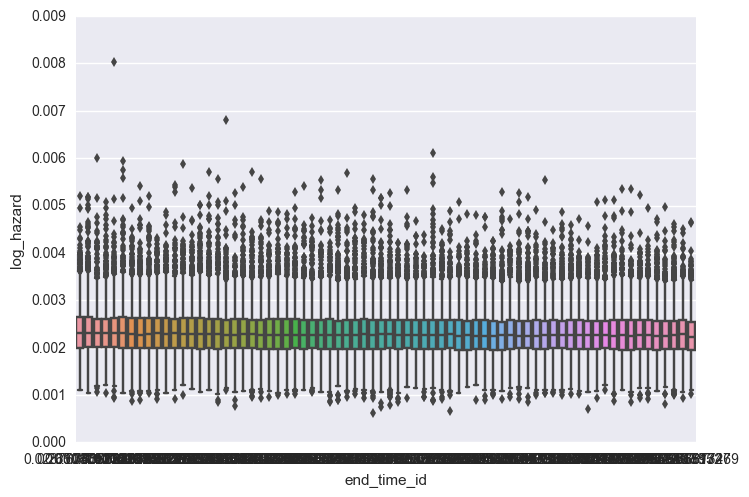

In [19]:
survivalstan.utils.plot_coefs([testfit], element='baseline')

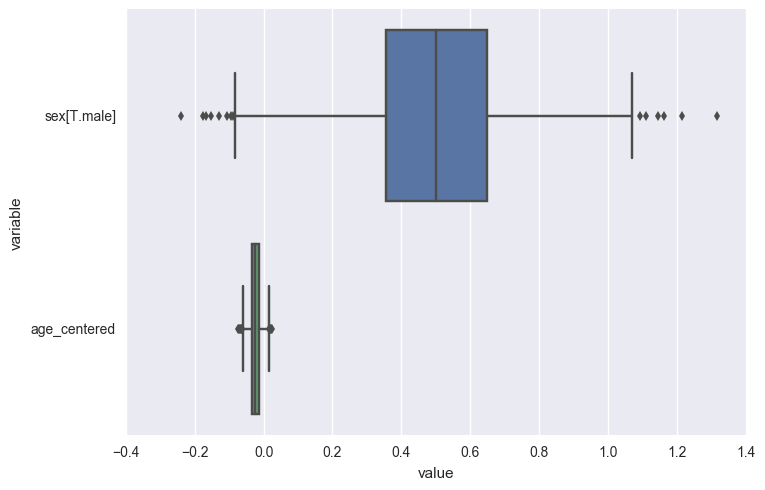

In [20]:
survivalstan.utils.plot_coefs([testfit])

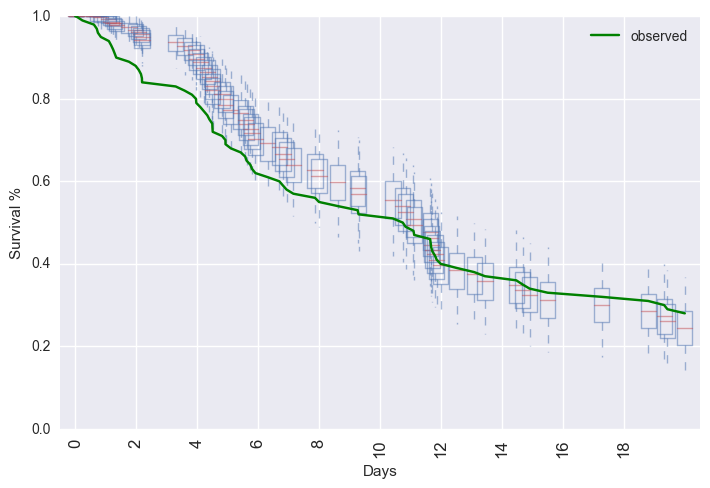

In [25]:
survivalstan.utils.plot_pp_survival([testfit], fill=False)
survivalstan.utils.plot_observed_survival(df=d, event_col='event', time_col='t', color='green', label='observed')
plt.legend()

In [26]:
ppsurv = survivalstan.utils.prep_pp_survival_data([testfit], by='sex')

In [27]:
ppsurv.head()

,iter,model_cohort,sex,level_3,event_time,survival
0,0,test model,female,0,0.000000,1.000000
1,0,test model,female,1,1.101821,1.000000
2,0,test model,female,2,1.239425,0.970325
3,0,test model,female,3,1.980062,0.946341
4,0,test model,female,4,2.192091,0.935772


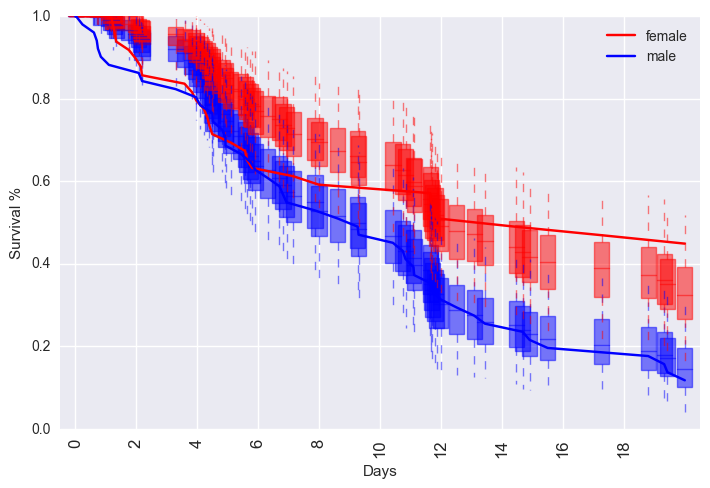

In [28]:
subplot = plt.subplots(1, 1)
survivalstan.utils._plot_pp_survival_data(ppsurv.query('sex == "male"').copy(), subplot=subplot, color='blue', alpha=0.5)
survivalstan.utils._plot_pp_survival_data(ppsurv.query('sex == "female"').copy(), subplot=subplot, color='red', alpha=0.5)
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t',
                                          color='red', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t',
                                          color='blue', label='male')
plt.legend()

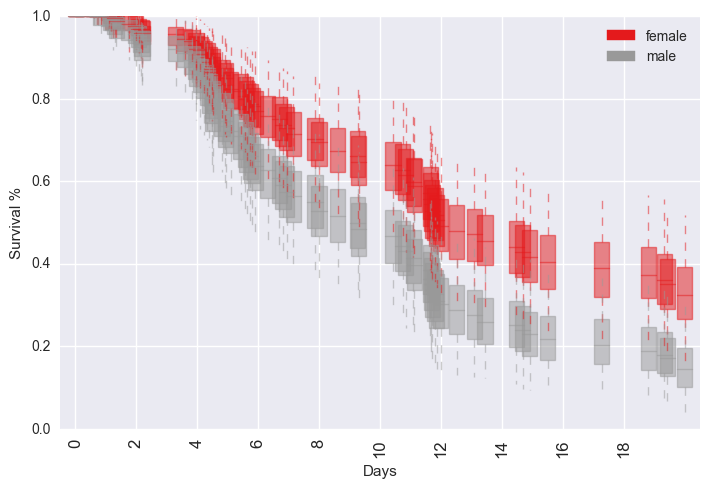

In [29]:
survivalstan.utils.plot_pp_survival([testfit], by='sex')

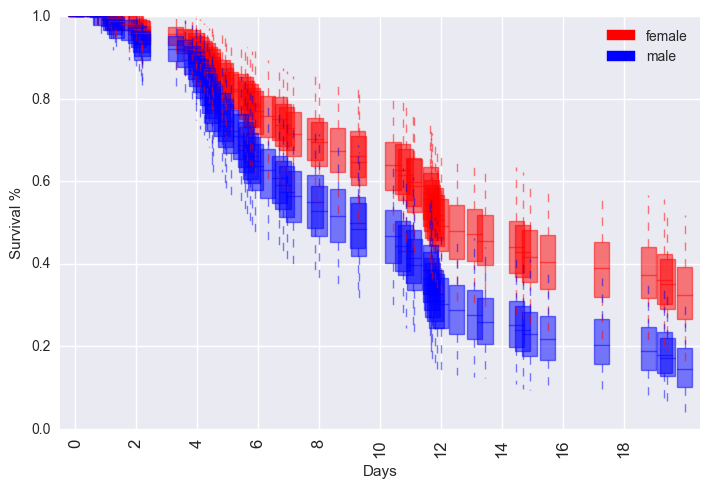

In [30]:
survivalstan.utils.plot_pp_survival([testfit], by='sex', pal=['red', 'blue'])